In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from utils import *
import blinpy as bp

import gammy
from gammy.arraymapper import x
from gammy.models.bayespy import GAM

from scipy.interpolate import RegularGridInterpolator
from scipy import sparse
from scipy.optimize import minimize

In [2]:
X_train = pd.read_csv('data/X_train_PM2.5.csv')
X_test = pd.read_csv('data/X_test_PM2.5.csv')
y_train = pd.read_csv('data/y_train_PM2.5.csv')
y_test = pd.read_csv('data/y_test_PM2.5.csv')

In [3]:
result_train = pd.DataFrame()
result_test = pd.DataFrame()

In [4]:
X_train.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

### Linear Regression

In [5]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Performance
train_performance = {
    'Model': ['Linear Regression'],
    'Mean Square Error': [mean_squared_error(y_train, y_train_pred)],
    'Root Mean Square Error': [mean_squared_error(y_train, y_train_pred, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_train, y_train_pred)],
    'R2 Score': [r2_score(y_train, y_train_pred)]
}

test_performance = {
    'Model': ['Linear Regression'],
    'Mean Square Error': [mean_squared_error(y_test, y_test_pred)],
    'Root Mean Square Error': [mean_squared_error(y_test, y_test_pred, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_test, y_test_pred)],
    'R2 Score': [r2_score(y_test, y_test_pred)]
}

result_train = pd.DataFrame(pd.concat([result_train, pd.DataFrame(train_performance)], ignore_index=True))
result_test = pd.DataFrame(pd.concat([result_test, pd.DataFrame(test_performance)], ignore_index=True))
result_train.head()


,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.041791,0.204429,0.124798,0.906273


In [6]:
result_test.head()

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.043389,0.208299,0.125495,0.903937


### Random Forest with Bayesian Optimization

In [7]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

def rf_optimization(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    
    rf = RandomForestRegressor(n_estimators=n_estimators,
                               max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return -mse

bounds = {
    'n_estimators': (10, 200),
    'max_depth': (1, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

optimizer = BayesianOptimization(f=rf_optimization, pbounds=bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

best_params_bayes = optimizer.max['params']
best_params_bayes['n_estimators'] = int(best_params_bayes['n_estimators'])
best_params_bayes['max_depth'] = int(best_params_bayes['max_depth'])
best_params_bayes['min_samples_split'] = int(best_params_bayes['min_samples_split'])
best_params_bayes['min_samples_leaf'] = int(best_params_bayes['min_samples_leaf'])

print("Best Parameters for Random Forest (Bayesian Optimization):", best_params_bayes)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.04036  | 11.86     | 3.852     | 7.856     | 123.7     |
| 2         | -0.04166  | 5.525     | 1.468     | 2.465     | 174.6     |
| 3         | -0.0409   | 18.43     | 3.124     | 2.165     | 194.3     |
| 4         | -0.04275  | 25.14     | 1.637     | 3.455     | 44.85     |
| 5         | -0.04069  | 9.823     | 2.574     | 5.456     | 65.33     |
| 6         | -0.04042  | 12.21     | 3.654     | 8.831     | 123.8     |
| 7         | -0.04133  | 5.8       | 3.174     | 2.035     | 109.4     |
| 8         | -0.04036  | 9.533     | 3.224     | 2.046     | 134.0     |
| 9         | -0.0419   | 25.97     | 1.263     | 2.037     | 131.0     |
| 10        | -0.1482   | 1.126     | 1.571     | 8.398     | 127.7     |
| 11        | -0.04147  | 19.58     | 2.694     | 4.201     | 123.6     |
| 12        | -0.04059  | 18.04     | 

In [8]:
best_rf = RandomForestRegressor(**best_params_bayes, random_state=42)
best_rf.fit(X_train, y_train)

y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

train_performance = {
    'Model': ['Random Forest'],
    'Mean Square Error': [mean_squared_error(y_train, y_train_pred_rf)],
    'Root Mean Square Error': [mean_squared_error(y_train, y_train_pred_rf, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_train, y_train_pred_rf)],
    'R2 Score': [r2_score(y_train, y_train_pred_rf)]
}

test_performance = {
    'Model': ['Random Forest'],
    'Mean Square Error': [mean_squared_error(y_test, y_test_pred_rf)],
    'Root Mean Square Error': [mean_squared_error(y_test, y_test_pred_rf, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_test, y_test_pred_rf)],
    'R2 Score': [r2_score(y_test, y_test_pred_rf)]
}

result_train = pd.DataFrame(pd.concat([result_train, pd.DataFrame(train_performance)], ignore_index=True))
result_test = pd.DataFrame(pd.concat([result_test, pd.DataFrame(test_performance)], ignore_index=True))
result_train.head()

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.041791,0.204429,0.124798,0.906273
1,Random Forest,0.031482,0.177432,0.111289,0.929393


In [9]:
result_test.head()

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.043389,0.208299,0.125495,0.903937
1,Random Forest,0.040227,0.200567,0.121238,0.910937


### Frequentist Penalized B-Splines

In [10]:
from pygam import LinearGAM, s, l

# Define the model with splines for each variable
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8)).fit(X_train, y_train)

lams = np.logspace(-3, 3, 10)
gam.gridsearch(X_train, y_train, lam=lams)

y_train_pred_gam = gam.predict(X_train)
y_test_pred_gam = gam.predict(X_test)

  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 10% (1 of 10) |##                       | Elapsed Time: 0:00:01 ETA:   0:00:15
 20% (2 of 10) |#####                    | Elapsed Time: 0:00:03 ETA:   0:00:13
 30% (3 of 10) |#######                  | Elapsed Time: 0:00:05 ETA:   0:00:12
 40% (4 of 10) |##########               | Elapsed Time: 0:00:07 ETA:   0:00:11
 50% (5 of 10) |############             | Elapsed Time: 0:00:09 ETA:   0:00:10
 60% (6 of 10) |###############          | Elapsed Time: 0:00:10 ETA:   0:00:07
 70% (7 of 10) |#################        | Elapsed Time: 0:00:12 ETA:   0:00:05
 80% (8 of 10) |####################     | Elapsed Time: 0:00:14 ETA:   0:00:03
 90% (9 of 10) |######################   | Elapsed Time: 0:00:16 ETA:   0:00:01
100% (10 of 10) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


In [11]:
train_performance = {
    'Model': ['Frequentist Penalized Splines'],
    'Mean Square Error': [mean_squared_error(y_train, y_train_pred_gam)],
    'Root Mean Square Error': [mean_squared_error(y_train, y_train_pred_gam, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_train, y_train_pred_gam)],
    'R2 Score': [r2_score(y_train, y_train_pred_gam)]
}

test_performance = {
    'Model': ['Frequentist Penalized Splines'],
    'Mean Square Error': [mean_squared_error(y_test, y_test_pred_gam)],
    'Root Mean Square Error': [mean_squared_error(y_test, y_test_pred_gam, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_test, y_test_pred_gam)],
    'R2 Score': [r2_score(y_test, y_test_pred_gam)]
}

result_train = pd.DataFrame(pd.concat([result_train, pd.DataFrame(train_performance)], ignore_index=True))
result_test = pd.DataFrame(pd.concat([result_test, pd.DataFrame(test_performance)], ignore_index=True))
result_train.head()

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.041791,0.204429,0.124798,0.906273
1,Random Forest,0.031482,0.177432,0.111289,0.929393
2,Frequentist Penalized Splines,0.039135,0.197827,0.120681,0.912229


In [12]:
result_test.head()

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.043389,0.208299,0.125495,0.903937
1,Random Forest,0.040227,0.200567,0.121238,0.910937
2,Frequentist Penalized Splines,0.040531,0.201322,0.121427,0.910265


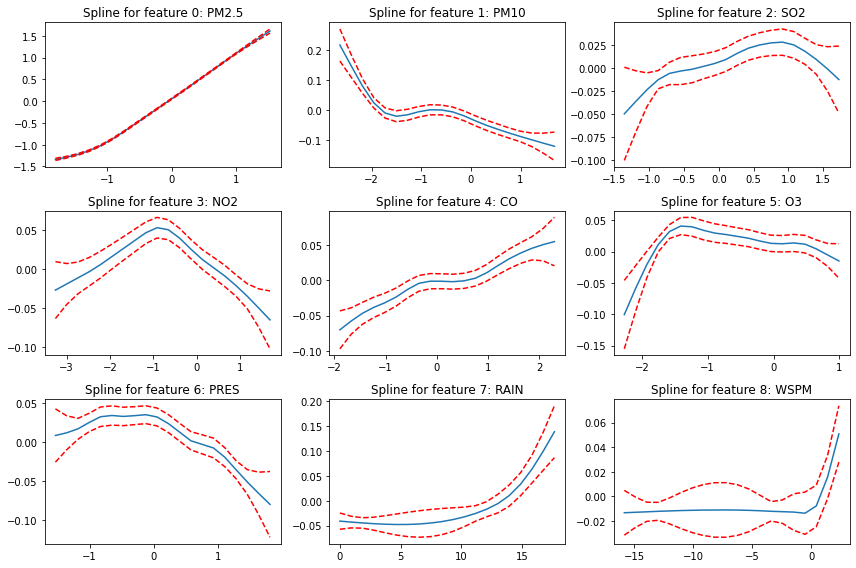

In [13]:
columns_to_plot = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'PRES', 'RAIN', 'WSPM']
def generate_X_grid(X, feature, n_points=20):
    x_min, x_max = X.iloc[:, feature].min(), X.iloc[:, feature].max()
    x_grid = np.linspace(x_min, x_max, num=n_points)
    X_grid = X.copy()

    X_result_list = []
    for i in range(n_points):
        X_grid.iloc[:, feature] = x_grid[i]
        X_result_list.append(X_grid.copy())
    
    X_result = pd.concat(X_result_list, ignore_index=True)
    return X_result

fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    if i < 9:
        XX = generate_X_grid(X_train, i)  # Use the custom generate_X_grid function
        ax.plot(XX.iloc[:, i], gam.partial_dependence(term=i, X=XX))
        ax.plot(XX.iloc[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        ax.set_title(f'Spline for feature {i}: {columns_to_plot[i]}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

### Gaussian Process Priors

In [14]:
X_train_gam = np.array(X_train)
X_test_gam = np.array(X_test)
y_train_gam = np.array(y_train).reshape(-1)
y_test_gam = np.array(y_test).reshape(-1)

In [15]:
a = gammy.ExpSquared1d(
    np.arange(-2, 1.6, 0.01),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 0])
b = gammy.ExpSquared1d(
    np.arange(-0.12, 1.7, 0.01),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 1])
c = gammy.ExpSquared1d(
    np.arange(-1.4, 1.8, 0.01),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 2])
d = gammy.ExpSquared1d(
    np.arange(-3.3, 1.7, 0.01),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 3])
e = gammy.ExpSquared1d(
    np.arange(-2, 2.3, 0.01),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 4])
f = gammy.ExpSquared1d(
    np.arange(-2.3, 1, 0.01),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 5])
g = gammy.ExpSquared1d(
    np.arange(-1.6, 1.9, 0.01),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 6])
h= gammy.ExpSquared1d(
    np.arange(0, 18, 2),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 7])
i = gammy.ExpSquared1d(
    np.arange(-5, 2, 0.01),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 8])

formula = a + b + c + d + e + h + i
model = gammy.models.bayespy.GAM(formula).fit(X_train_gam, y_train_gam)

In [16]:
y_pred_train_gammy = model.predict(X_train_gam)
y_pred_test_gammy = model.predict(X_test_gam)

train_performance = {
    'Model': ['Gaussian Process (Exponential Squared)'],
    'Mean Square Error': [mean_squared_error(y_train_gam, y_pred_train_gammy)],
    'Root Mean Square Error': [mean_squared_error(y_train_gam, y_pred_train_gammy, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_train_gam, y_pred_train_gammy)],
    'R2 Score': [r2_score(y_train_gam, y_pred_train_gammy)]
}

test_performance = {
    'Model': ['Gaussian Process (Exponential Squared)'],
    'Mean Square Error': [mean_squared_error(y_test_gam, y_pred_test_gammy)],
    'Root Mean Square Error': [mean_squared_error(y_test_gam, y_pred_test_gammy, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_test_gam, y_pred_test_gammy)],
    'R2 Score': [r2_score(y_test_gam, y_pred_test_gammy)]
}

In [17]:
result_train = pd.DataFrame(pd.concat([result_train, pd.DataFrame(train_performance)], ignore_index=True))
result_test = pd.DataFrame(pd.concat([result_test, pd.DataFrame(test_performance)], ignore_index=True))
result_train.head()

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.041791,0.204429,0.124798,0.906273
1,Random Forest,0.031482,0.177432,0.111289,0.929393
2,Frequentist Penalized Splines,0.039135,0.197827,0.120681,0.912229
3,Gaussian Process (Exponential Squared),0.039246,0.198106,0.121153,0.911982


In [18]:
result_test.head()

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.043389,0.208299,0.125495,0.903937
1,Random Forest,0.040227,0.200567,0.121238,0.910937
2,Frequentist Penalized Splines,0.040531,0.201322,0.121427,0.910265
3,Gaussian Process (Exponential Squared),0.040964,0.202397,0.122669,0.909305


In [19]:
a = gammy.RationalQuadratic1d(
    np.arange(-2, 1.6, 0.01),
    corrlen=0.1,
    sigma=1.0,
    alpha=1,
    energy=0.99
)(x[:, 0])
b = gammy.RationalQuadratic1d(
    np.arange(-0.12, 1.7, 0.01),
    corrlen=0.1,
    sigma=1.0,
    alpha=1,
    energy=0.99
)(x[:, 1])
c = gammy.RationalQuadratic1d(
    np.arange(-1.4, 1.8, 0.01),
    corrlen=0.1,
    sigma=1.0,
    alpha=1,
    energy=0.99
)(x[:, 2])
d = gammy.RationalQuadratic1d(
    np.arange(-3.3, 1.7, 0.01),
    corrlen=0.1,
    sigma=1.0,
    alpha=1,
    energy=0.99
)(x[:, 3])
e = gammy.RationalQuadratic1d(
    np.arange(-2, 2.3, 0.01),
    corrlen=0.1,
    sigma=1.0,
    alpha=1,
    energy=0.99
)(x[:, 4])
f = gammy.RationalQuadratic1d(
    np.arange(-2.3, 1, 0.01),
    corrlen=0.1,
    sigma=1.0,
    alpha=1,
    energy=0.99
)(x[:, 5])
g = gammy.RationalQuadratic1d(
    np.arange(-1.6, 1.9, 0.01),
    corrlen=0.1,
    sigma=1.0,
    alpha=1,
    energy=0.99
)(x[:, 6])
h= gammy.RationalQuadratic1d(
    np.arange(0, 18, 2),
    corrlen=0.1,
    sigma=1.0,
    alpha=1,
    energy=0.99
)(x[:, 7])
i = gammy.RationalQuadratic1d(
    np.arange(-5, 2, 0.01),
    corrlen=0.1,
    sigma=1.0,
    alpha=1,
    energy=0.99
)(x[:, 8])

formula = a + b + c + d + e + h + i
model = gammy.models.bayespy.GAM(formula).fit(X_train_gam, y_train_gam)

In [20]:
y_pred_train_gammy = model.predict(X_train_gam)
y_pred_test_gammy = model.predict(X_test_gam)

train_performance = {
    'Model': ['Gaussian Process (Rational Quadratic)'],
    'Mean Square Error': [mean_squared_error(y_train_gam, y_pred_train_gammy)],
    'Root Mean Square Error': [mean_squared_error(y_train_gam, y_pred_train_gammy, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_train_gam, y_pred_train_gammy)],
    'R2 Score': [r2_score(y_train_gam, y_pred_train_gammy)]
}

test_performance = {
    'Model': ['Gaussian Process (Rational Quadratic)'],
    'Mean Square Error': [mean_squared_error(y_test_gam, y_pred_test_gammy)],
    'Root Mean Square Error': [mean_squared_error(y_test_gam, y_pred_test_gammy, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_test_gam, y_pred_test_gammy)],
    'R2 Score': [r2_score(y_test_gam, y_pred_test_gammy)]
}

result_train = pd.DataFrame(pd.concat([result_train, pd.DataFrame(train_performance)], ignore_index=True))
result_test = pd.DataFrame(pd.concat([result_test, pd.DataFrame(test_performance)], ignore_index=True))
result_train.head(10)

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.041791,0.204429,0.124798,0.906273
1,Random Forest,0.031482,0.177432,0.111289,0.929393
2,Frequentist Penalized Splines,0.039135,0.197827,0.120681,0.912229
3,Gaussian Process (Exponential Squared),0.039246,0.198106,0.121153,0.911982
4,Gaussian Process (Rational Quadratic),0.039189,0.197963,0.121193,0.912108


In [21]:
result_test.head(10)

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.043389,0.208299,0.125495,0.903937
1,Random Forest,0.040227,0.200567,0.121238,0.910937
2,Frequentist Penalized Splines,0.040531,0.201322,0.121427,0.910265
3,Gaussian Process (Exponential Squared),0.040964,0.202397,0.122669,0.909305
4,Gaussian Process (Rational Quadratic),0.040988,0.202456,0.122855,0.909252


In [22]:
a = gammy.OrnsteinUhlenbeck1d(
    np.arange(-2, 1.6, 0.1),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 0])
b = gammy.OrnsteinUhlenbeck1d(
    np.arange(-0.12, 1.7, 0.1),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 1])
c = gammy.OrnsteinUhlenbeck1d(
    np.arange(-1.4, 1.8, 0.1),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 2])
d = gammy.OrnsteinUhlenbeck1d(
    np.arange(-3.3, 1.7, 0.1),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 3])
e = gammy.OrnsteinUhlenbeck1d(
    np.arange(-2, 2.3, 0.1),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 4])
f = gammy.OrnsteinUhlenbeck1d(
    np.arange(-2.3, 1, 0.1),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 5])
g = gammy.OrnsteinUhlenbeck1d(
    np.arange(-1.6, 1.9, 0.5),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 6])
h= gammy.OrnsteinUhlenbeck1d(
    np.arange(0, 18, 2),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 7])
i = gammy.OrnsteinUhlenbeck1d(
    np.arange(-5, 2, 0.1),
    corrlen=0.1,
    sigma=1.0,
    energy=0.99
)(x[:, 8])

formula = a + b + c + d + e + h + i
model = gammy.models.bayespy.GAM(formula).fit(X_train_gam, y_train_gam)

In [23]:
y_train_pred_gammy = model.predict(X_train_gam)
y_test_pred_gammy = model.predict(X_test_gam)

train_performance = {
    'Model': ['Gaussian Process (Ornstein-Uhlenbeck)'],
    'Mean Square Error': [mean_squared_error(y_train_gam, y_train_pred_gammy)],
    'Root Mean Square Error': [mean_squared_error(y_train_gam, y_train_pred_gammy, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_train_gam, y_train_pred_gammy)],
    'R2 Score': [r2_score(y_train_gam, y_train_pred_gammy)]
}

test_performance = {
    'Model': ['Gaussian Process (Ornstein-Uhlenbeck)'],
    'Mean Square Error': [mean_squared_error(y_test_gam, y_test_pred_gammy)],
    'Root Mean Square Error': [mean_squared_error(y_test_gam, y_test_pred_gammy, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_test_gam, y_test_pred_gammy)],
    'R2 Score': [r2_score(y_test_gam, y_test_pred_gammy)]
}

result_train = pd.DataFrame(pd.concat([result_train, pd.DataFrame(train_performance)], ignore_index=True))
result_test = pd.DataFrame(pd.concat([result_test, pd.DataFrame(test_performance)], ignore_index=True))
result_train.head(10)

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.041791,0.204429,0.124798,0.906273
1,Random Forest,0.031482,0.177432,0.111289,0.929393
2,Frequentist Penalized Splines,0.039135,0.197827,0.120681,0.912229
3,Gaussian Process (Exponential Squared),0.039246,0.198106,0.121153,0.911982
4,Gaussian Process (Rational Quadratic),0.039189,0.197963,0.121193,0.912108
5,Gaussian Process (Ornstein-Uhlenbeck),0.039210,0.198014,0.121232,0.912063


In [24]:
result_test.head(10)

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.043389,0.208299,0.125495,0.903937
1,Random Forest,0.040227,0.200567,0.121238,0.910937
2,Frequentist Penalized Splines,0.040531,0.201322,0.121427,0.910265
3,Gaussian Process (Exponential Squared),0.040964,0.202397,0.122669,0.909305
4,Gaussian Process (Rational Quadratic),0.040988,0.202456,0.122855,0.909252
5,Gaussian Process (Ornstein-Uhlenbeck),0.040953,0.202369,0.122749,0.909330


### Process Priors

In [25]:
X_train = pd.read_csv('data/X_train_PM2.5.csv')
X_test = pd.read_csv('data/X_test_PM2.5.csv')
y_train = pd.read_csv('data/y_train_PM2.5.csv')
y_test = pd.read_csv('data/y_test_PM2.5.csv')
X_train = X_train.rename(columns={'0':'x1', '1':'x2', '2':'x3', '3':'x4', '4':'x5', '5':'x6', '6':'x7', '7':'x8', '8':'x9'})
data = pd.concat([X_train, y_train], axis=1)
data = data.rename(columns={'0':'y'})
X_test = X_test.rename(columns={'0':'x1', '1':'x2', '2':'x3', '3':'x4', '4':'x5', '5':'x6', '6':'x7', '7':'x8', '8':'x9'})
data_test = pd.concat([X_test, y_test], axis=1)
data_test = data_test.rename(columns={'0':'y'})

In [26]:
x1_fit = np.linspace(-2, 1.6, 100)
x2_fit = np.linspace(-0.13, 1.7, 100)
x3_fit = np.linspace(-1.4, 1.8, 100)
x4_fit = np.linspace(-3.3, 1.7, 100)
x5_fit = np.linspace(-2, 2.3, 100)
x6_fit = np.linspace(-2.3, 1, 100)
x7_fit = np.linspace(-1.6, 1.9, 100)
x8_fit = np.linspace(0, 1, 100)
x9_fit = np.linspace(-5, 2, 100)
nfit0 = len(x1_fit)
nfit1 = len(x2_fit)
nfit2 = len(x3_fit)
nfit3 = len(x4_fit)
nfit4 = len(x5_fit)
nfit5 = len(x6_fit)
nfit6 = len(x7_fit)
nfit7 = len(x8_fit)
nfit8 = len(x9_fit)

In [27]:
## Model 1 : Smooth functions
gam_specs1 = lambda logv: [
    smooth_diff1('x1', x1_fit, diff_std=np.exp(logv[0]), mu=np.mean(data.y.values), std=1),
    smooth_diff1('x2', x2_fit, diff_std=np.exp(logv[1]), mu=np.mean(data.y.values), std=1),
    smooth_diff1('x3', x3_fit, diff_std=np.exp(logv[2]), mu=np.mean(data.y.values), std=1),
    smooth_diff1('x4', x4_fit, diff_std=np.exp(logv[3]), mu=np.mean(data.y.values), std=1),
    smooth_diff1('x5', x5_fit, diff_std=np.exp(logv[4]), mu=np.mean(data.y.values), std=1),
    smooth_diff1('x6', x6_fit, diff_std=np.exp(logv[5]), mu=np.mean(data.y.values), std=1),
    smooth_diff1('x7', x7_fit, diff_std=np.exp(logv[6]), mu=np.mean(data.y.values), std=1),
    smooth_diff1('x8', x8_fit, diff_std=np.exp(logv[7]), mu=np.mean(data.y.values), std=1),
    smooth_diff1('x9', x9_fit, diff_std=np.exp(logv[8]), mu=np.mean(data.y.values), std=1)
]

In [28]:
model = bp.models.GamModel('y', gam_specs1((0.667,0.7, 0.6, 0.7,0.7,0.7,0.7,3,3))).fit(data, obs_cov=0.1**2)

y_train_pred = model.predict(data)
y_test_pred = model.predict(data_test)

train_performance = {
    'Model': ['Difference Priors (Smooth functions)'],
    'Mean Square Error': [mean_squared_error(y_train, y_train_pred)],
    'Root Mean Square Error': [mean_squared_error(y_train, y_train_pred, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_train, y_train_pred)],
    'R2 Score': [r2_score(y_train, y_train_pred)]
}

test_performance = {
    'Model': ['Difference Priors (Smooth functions)'],
    'Mean Square Error': [mean_squared_error(y_test, y_test_pred)],
    'Root Mean Square Error': [mean_squared_error(y_test, y_test_pred, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_test, y_test_pred)],
    'R2 Score': [r2_score(y_test, y_test_pred)]
}

result_train = pd.DataFrame(pd.concat([result_train, pd.DataFrame(train_performance)], ignore_index=True))
result_test = pd.DataFrame(pd.concat([result_test, pd.DataFrame(test_performance)], ignore_index=True))
result_train.head(10)

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.041791,0.204429,0.124798,0.906273
1,Random Forest,0.031482,0.177432,0.111289,0.929393
2,Frequentist Penalized Splines,0.039135,0.197827,0.120681,0.912229
3,Gaussian Process (Exponential Squared),0.039246,0.198106,0.121153,0.911982
4,Gaussian Process (Rational Quadratic),0.039189,0.197963,0.121193,0.912108
5,Gaussian Process (Ornstein-Uhlenbeck),0.039210,0.198014,0.121232,0.912063
6,Difference Priors (Smooth functions),0.038189,0.195420,0.121443,0.914352


In [29]:
result_test.head(10)

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.043389,0.208299,0.125495,0.903937
1,Random Forest,0.040227,0.200567,0.121238,0.910937
2,Frequentist Penalized Splines,0.040531,0.201322,0.121427,0.910265
3,Gaussian Process (Exponential Squared),0.040964,0.202397,0.122669,0.909305
4,Gaussian Process (Rational Quadratic),0.040988,0.202456,0.122855,0.909252
5,Gaussian Process (Ornstein-Uhlenbeck),0.040953,0.202369,0.122749,0.909330
6,Difference Priors (Smooth functions),0.041526,0.203780,0.125011,0.908060


In [30]:
## Method 2: Periodic Functions
gam_specs2 = lambda logv: [
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x1'].values, x1_fit),
        'name': 'f(x1)',
        'prior': {
            'B': bp.utils.diffmat(nfit0, order=2, periodic=True),
            'mu': np.zeros(nfit0),
            'cov': 0.7*np.ones(nfit0),
        }
    },
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x2'].values, x2_fit),
        'name': 'f(x2)',
        'prior': {
            'B': bp.utils.diffmat(nfit1, order=2, periodic=True),
            'mu': np.zeros(nfit1),
            'cov': 0.7*np.ones(nfit1),
        }
    },
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x3'].values, x3_fit),
        'name': 'f(x3)',
        'prior': {
            'B': bp.utils.diffmat(nfit2, order=2, periodic=True),
            'mu': np.zeros(nfit2),
            'cov': np.concatenate((np.exp(logv[1])*np.ones(nfit2-2), 0.7*np.ones(2))),
        }
    },
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x4'].values, x4_fit),
        'name': 'f(x4)',
        'prior': {
            'B': bp.utils.diffmat(nfit3, order=2, periodic=True),
            'mu': np.zeros(nfit3),
            'cov': np.concatenate((np.exp(logv[1])*np.ones(nfit3-2), 0.7*np.ones(2))),
        }
    },
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x5'].values, x5_fit),
        'name': 'f(x5)',
        'prior': {
            'B': bp.utils.diffmat(nfit4, order=2, periodic=True),
            'mu': np.zeros(nfit4),
            'cov': np.concatenate((np.exp(logv[1])*np.ones(nfit4-2), 0.7*np.ones(2))),
        }
    },
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x6'].values, x6_fit),
        'name': 'f(x6)',
        'prior': {
            'B': bp.utils.diffmat(nfit5, order=2, periodic=True),
            'mu': np.zeros(nfit5),
            'cov': np.concatenate((np.exp(logv[1])*np.ones(nfit5-2), 0.7*np.ones(2))),
        }
    },
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x7'].values, x7_fit),
        'name': 'f(x7)',
        'prior': {
            'B': bp.utils.diffmat(nfit6, order=2, periodic=True),
            'mu': np.zeros(nfit6),
            'cov': np.concatenate((np.exp(logv[1])*np.ones(nfit6-2), 0.7*np.ones(2))),
        }
    },
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x8'].values, x8_fit),
        'name': 'f(x8)',
        'prior': {
            'B': bp.utils.diffmat(nfit7, order=2, periodic=True),
            'mu': np.zeros(nfit7),
            'cov': np.concatenate((np.exp(logv[1])*np.ones(nfit7-2), 0.01*np.ones(2))),
        }
    },
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x9'].values, x9_fit),
        'name': 'f(x9)',
        'prior': {
            'B': bp.utils.diffmat(nfit8, order=2, periodic=True),
            'mu': np.zeros(nfit8),
            'cov': np.concatenate((np.exp(logv[1])*np.ones(nfit8-2), 3*np.ones(2))),
        }
    }
]

In [31]:
model = bp.models.GamModel('y', gam_specs2((0.667,0.7, 0.6, 0.7,0.7,0.7,0.7,3,3))).fit(data, obs_cov=0.1**2)

y_train_pred = model.predict(data)
y_test_pred = model.predict(data_test)

train_performance = {
    'Model': ['Difference Priors (Periodic functions)'],
    'Mean Square Error': [mean_squared_error(y_train, y_train_pred)],
    'Root Mean Square Error': [mean_squared_error(y_train, y_train_pred, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_train, y_train_pred)],
    'R2 Score': [r2_score(y_train, y_train_pred)]
}

test_performance = {
    'Model': ['Difference Priors (Periodic functions)'],
    'Mean Square Error': [mean_squared_error(y_test, y_test_pred)],
    'Root Mean Square Error': [mean_squared_error(y_test, y_test_pred, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_test, y_test_pred)],
    'R2 Score': [r2_score(y_test, y_test_pred)]
}

result_train = pd.concat([result_train, pd.DataFrame(train_performance)], ignore_index=True)
result_test = pd.concat([result_test, pd.DataFrame(test_performance)], ignore_index=True)

result_train.head(10)

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.041791,0.204429,0.124798,0.906273
1,Random Forest,0.031482,0.177432,0.111289,0.929393
2,Frequentist Penalized Splines,0.039135,0.197827,0.120681,0.912229
3,Gaussian Process (Exponential Squared),0.039246,0.198106,0.121153,0.911982
4,Gaussian Process (Rational Quadratic),0.039189,0.197963,0.121193,0.912108
5,Gaussian Process (Ornstein-Uhlenbeck),0.039210,0.198014,0.121232,0.912063
6,Difference Priors (Smooth functions),0.038189,0.195420,0.121443,0.914352
7,Difference Priors (Periodic functions),0.038189,0.195420,0.121439,0.914352


In [32]:
result_test.head(10)

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.043389,0.208299,0.125495,0.903937
1,Random Forest,0.040227,0.200567,0.121238,0.910937
2,Frequentist Penalized Splines,0.040531,0.201322,0.121427,0.910265
3,Gaussian Process (Exponential Squared),0.040964,0.202397,0.122669,0.909305
4,Gaussian Process (Rational Quadratic),0.040988,0.202456,0.122855,0.909252
5,Gaussian Process (Ornstein-Uhlenbeck),0.040953,0.202369,0.122749,0.909330
6,Difference Priors (Smooth functions),0.041526,0.203780,0.125011,0.908060
7,Difference Priors (Periodic functions),0.041588,0.203932,0.125091,0.907924


In [33]:
gam_specs3 = lambda logv: [
    smooth_diff1('x1', x1_fit, diff_std=np.exp(logv[0]), mu=np.mean(data.y.values), std=0.6),
    smooth_diff1('x2', x2_fit, diff_std=np.exp(logv[0]), mu=np.mean(data.y.values), std=0.6),
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x3'].values, x3_fit),
        'name': 'f(x3)',
        'prior': {
            'B': bp.utils.diffmat(nfit2, order=2, periodic=True),
            'mu': np.zeros(nfit2),
            'cov': np.concatenate((np.exp(logv[1])*np.ones(nfit2-2), 0.7*np.ones(2))),
        }
    },
    smooth_diff1('x4', x4_fit, diff_std=np.exp(logv[0]), mu=np.mean(data.y.values), std=0.6),
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x5'].values, x5_fit),
        'name': 'f(x5)',
        'prior': {
            'B': bp.utils.diffmat(nfit4, order=2, periodic=True),
            'mu': np.zeros(nfit4),
            'cov': np.concatenate((np.exp(logv[1])*np.ones(nfit4-2), 0.7*np.ones(2))),
        }
    },
    smooth_diff1('x6', x6_fit, diff_std=np.exp(logv[0]), mu=np.mean(data.y.values), std=0.6),
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x7'].values, x7_fit),
        'name': 'f(x7)',
        'prior': {
            'B': bp.utils.diffmat(nfit6, order=2, periodic=True),
            'mu': np.zeros(nfit6),
            'cov': np.concatenate((np.exp(logv[1])*np.ones(nfit6-2), 0.7*np.ones(2))),
        }
    },
    smooth_diff1('x8', x8_fit, diff_std=np.exp(logv[0]), mu=np.mean(data.y.values), std=0.1),
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x9'].values, x9_fit),
        'name': 'f(x9)',
        'prior': {
            'B': bp.utils.diffmat(nfit8, order=2, periodic=True),
            'mu': np.zeros(nfit8),
            'cov': np.concatenate((np.exp(logv[1])*np.ones(nfit8-2), 3*np.ones(2))),
        }
    }
]

In [34]:
model = bp.models.GamModel('y', gam_specs3((0.667,0.7, 0.6, 0.7,0.7,0.7,0.7,0.1,3))).fit(data, obs_cov=0.1**2)

y_train_pred = model.predict(data)
y_test_pred = model.predict(data_test)

train_performance = {
    'Model': ['Difference Priors (Mixture of Smooth + Periodic functions)'],
    'Mean Square Error': [mean_squared_error(y_train, y_train_pred)],
    'Root Mean Square Error': [mean_squared_error(y_train, y_train_pred, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_train, y_train_pred)],
    'R2 Score': [r2_score(y_train, y_train_pred)]
}

test_performance = {
    'Model': ['Difference Priors (Mixture of Smooth + Periodic functions)'],
    'Mean Square Error': [mean_squared_error(y_test, y_test_pred)],
    'Root Mean Square Error': [mean_squared_error(y_test, y_test_pred, squared=False)],
    'Mean Absolute Error': [mean_absolute_error(y_test, y_test_pred)],
    'R2 Score': [r2_score(y_test, y_test_pred)]
}

result_train = pd.concat([result_train, pd.DataFrame(train_performance)], ignore_index=True)
result_test = pd.concat([result_test, pd.DataFrame(test_performance)], ignore_index=True)
result_train.head(10)

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.041791,0.204429,0.124798,0.906273
1,Random Forest,0.031482,0.177432,0.111289,0.929393
2,Frequentist Penalized Splines,0.039135,0.197827,0.120681,0.912229
3,Gaussian Process (Exponential Squared),0.039246,0.198106,0.121153,0.911982
4,Gaussian Process (Rational Quadratic),0.039189,0.197963,0.121193,0.912108
5,Gaussian Process (Ornstein-Uhlenbeck),0.039210,0.198014,0.121232,0.912063
6,Difference Priors (Smooth functions),0.038189,0.195420,0.121443,0.914352
7,Difference Priors (Periodic functions),0.038189,0.195420,0.121439,0.914352
8,Difference Priors (Mixture of Smooth + Periodi...,0.038190,0.195422,0.121457,0.914350


In [35]:
result_test.head(10)

,Model,Mean Square Error,Root Mean Square Error,Mean Absolute Error,R2 Score
0,Linear Regression,0.043389,0.208299,0.125495,0.903937
1,Random Forest,0.040227,0.200567,0.121238,0.910937
2,Frequentist Penalized Splines,0.040531,0.201322,0.121427,0.910265
3,Gaussian Process (Exponential Squared),0.040964,0.202397,0.122669,0.909305
4,Gaussian Process (Rational Quadratic),0.040988,0.202456,0.122855,0.909252
5,Gaussian Process (Ornstein-Uhlenbeck),0.040953,0.202369,0.122749,0.909330
6,Difference Priors (Smooth functions),0.041526,0.203780,0.125011,0.908060
7,Difference Priors (Periodic functions),0.041588,0.203932,0.125091,0.907924
8,Difference Priors (Mixture of Smooth + Periodi...,0.041505,0.203728,0.124995,0.908108
